In [1]:
import numpy as np
from numpy import pi, cos, sin, array

In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=4, suppress=True)

In [3]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

## Curve Fitting

In [4]:
input_dbm = array([-10, -5, 0, 5, 10, 15, 20, 25])
output_dbm = array([0, 5.5, 10, 14, 18.5, 21, 21, 21])
ones = np.ones_like(input_dbm)

F = np.column_stack([ones, input_dbm, input_dbm**2, input_dbm**3])
A = np.linalg.inv(F.T@F)@F.T@output_dbm

input_range = np.arange(-10, 25, 0.1)
curve_fit = A[0] + A[1]*input_range + A[2]*input_range**2 + A[3]*input_range**3

A

array([10.1039,  0.9432, -0.01  , -0.0004])

In [5]:
# Solve using numpy
A_prime = np.polyfit(input_dbm, output_dbm, 3)
curve_fit_new = np.polyval(A_prime, input_range)

print(f'Max difference in coeffs: {np.max(A-A_prime[::-1]):.4f}')
print(f'Max difference in curvefit: {np.max(curve_fit - curve_fit_new):.4f}')
A_prime[::-1]

Max difference in coeffs: 0.0000
Max difference in curvefit: -0.0000


array([10.1039,  0.9432, -0.01  , -0.0004])

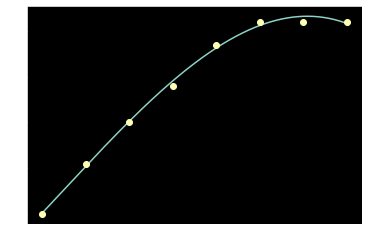

In [6]:
plt.plot(input_range, curve_fit)
plt.plot(input_dbm, output_dbm, 'o');

### Weighted LS

In [7]:
W = np.diag([1, 1, 1, 1, 1, 100, 100, 100])
A_weighted = np.linalg.inv(F.T@W@F)@F.T@W@output_dbm
curve_fit_weighted = A_weighted[0] + A_weighted[1]*input_range + A_weighted[2]*input_range**2 + A_weighted[3]*input_range**3

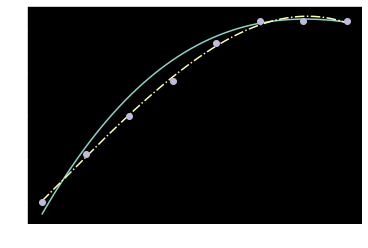

In [8]:
plt.plot(input_range, curve_fit_weighted)
plt.plot(input_range, curve_fit, '-.')
plt.plot(input_dbm, output_dbm, 'o');